In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
import aug_policy 
import torch

import os

np.random.seed(42)
import warnings
warnings.filterwarnings("ignore")

In [2]:
gts_final = gts = pd.read_csv("./train/train_gts_final.csv")
meta = pd.read_csv("./train/train_meta.csv")

df = meta.merge(gts_final, on='record_name')

Количество записей, где только одна единичка

In [3]:
df[df['норма'] != 1][['перегородочный', "передний", "боковой", "передне-боковой", 
                      "передне-перегородочный", "нижний"]].sum(axis=1).value_counts(normalize=True)

1    0.850602
2    0.146988
3    0.002410
Name: proportion, dtype: float64

количество единичек по каждой колонке

In [4]:
col_popularity = {}
for column in ['перегородочный', "передний", "боковой", "передне-боковой", "передне-перегородочный", "нижний"]:
    res = df[column].value_counts(normalize=True)[1]
    col_popularity.update({column:res})
col_popularity

{'перегородочный': 0.02760590195145169,
 'передний': 0.02617801047120419,
 'боковой': 0.0009519276534983341,
 'передне-боковой': 0.012375059495478343,
 'передне-перегородочный': 0.05663969538315088,
 'нижний': 0.10376011423131842}

колличество всех возможных комбинаций 0 и 1 (и закодированных в одну переменную - target)

In [5]:
df["target"] = ["".join(map(str, x)) for x in df[["перегородочный", "передний", "боковой", "передне-боковой", 
                             "передне-перегородочный", "нижний", "норма"]].to_numpy()]
TARGETS = list(set(df.target))
print(list(enumerate(TARGETS)))
df["target"] = df["target"].map(lambda x: TARGETS.index(x))

[(0, '0010000'), (1, '0100000'), (2, '0000110'), (3, '0000001'), (4, '0001000'), (5, '0100010'), (6, '0001010'), (7, '0000100'), (8, '1000000'), (9, '0101010'), (10, '1000010'), (11, '0000010'), (12, '0001100')]


In [6]:
df_test = pd.read_csv("./test/test_meta.csv")

In [7]:
def load_record(record_name, is_train):
    if is_train:
        with open(f"../task_final/train/{record_name}.npy", "rb") as f:
            data  = np.load(f, allow_pickle=True)
    else:
        with open(f"../task_final/test/{record_name}.npy", "rb") as f:
            data  = np.load(f, allow_pickle=True)
    return data

def print_beat(x, y, ecg_channel):
    fig, ax = plt.subplots()  # Create a figure containing a single axes.
    ax.set_title(f"ECG channel {ecg_channel}")
    ax.plot(x, y)  # Plot some data on the axes.

In [8]:
import multiprocessing



class Transformator():
    """ Класс-пайплайн от датафрейма train.gts до трансформированных данных ЭКГ.
    
    """
    def __init__(self,args, transformation_func, is_train):
        self.is_train = is_train
        self.args = args
        self.transformation_func = transformation_func
    
    def run_pipeline(self, df):
        
        result_df = self.pipeline_ecg(self.transformation_func, df)
        return result_df

    # transformation func - function that transforms record to any 
    def pipeline_ecg(self, transformation_func, df):

        result_df = df.copy()
        record_names = result_df['record_name'].to_list()
        result_df['correct_transformation'] = True
        path = ""
        if self.is_train: 
            if(not os.path.exists("./transformed_train/")):
                os.mkdir("./transformed_train/")
            path = "./transformed_train/"
        else:
            if(not os.path.exists("./transformed_test/")):
                os.mkdir("./transformed_test/")
            path = "./transformed_test/"

        new_names_column = [] 
        for record_name in tqdm(record_names):
            transformed = transformation_func(record_name, **self.args)
            # transformed - shape [12, 9] if preprocessing_with beats

            new_names = []
            for i in range(transformed.shape[1]):
                name = f"{record_name}_n{i}"
                new_names.append(name)
                np.save(path+name+".npy", transformed[:, i])
            new_names_column.append(new_names)
        result_df["new_name"] = new_names_column

        result_df = result_df.explode("new_name", ignore_index=True) 
        return result_df 

    def check_correctnes(self, df):
        test_df = df.iloc[:3]
        self.run_pipeline(test_df)


In [9]:
from preprocessing_with_beats import PipelineBeatExtraction
pipeline = PipelineBeatExtraction(prefix="./train", noise_level=2)
pipeline_test = PipelineBeatExtraction(prefix="./test", noise_level=2)
pipeline_func_test = pipeline_test.run_pipeline
pipeline_func = pipeline.run_pipeline

# transformator = Transformator({}, pipeline_func, is_train=True )
# transformator_test = Transformator({}, pipeline_func_test, is_train=False)


Проверка на правильность работы.

In [10]:
# transformator.check_correctnes(df)

In [11]:
# transformator_test.check_correctnes(df_test)

Запуск препроцессинга для тренировочных данных в многопроцессном режиме.

In [12]:
# from joblib import Parallel, delayed

# def process_dataframe(df):
#     result_df = transformator.pipeline_ecg(transformator.transformation_func, df)
#     return result_df

# process_num = 12

# result_test_dfs = Parallel(
#     n_jobs=process_num,
#     verbose=100
# )(
#     delayed(process_dataframe)(x) for x in np.array_split(df, process_num)
# )

# result_df = pd.concat(result_test_dfs)
# result_df.to_csv("transformed_df.csv")

In [13]:
# # Define the process_dataframe function
# process_num = 12

# def process_dataframe(df):
#     result_df = transformator.pipeline_ecg(transformator.transformation_func, df)
#     return result_df


# # Split your data into multiple dataframes
# dfs = np.array_split(df, process_num) 


# # Create a pool of worker processes
# pool = multiprocessing.Pool(processes=process_num)

# result_dfs = []
# # Run the process_dataframe function in parallel for each dataframe
# for result_df in tqdm(pool.imap(process_dataframe, dfs)):
#     result_dfs.append(result_df)

# # Close the pool of worker processes
# pool.close()
# pool.join()

# result_df = pd.concat(result_dfs)
# result_df.to_csv("transformed_df.csv")

Запуск препроцессинга для тестовых данных.

In [14]:
#from joblib import Parallel, delayed

# def process_dataframe(df):
#     result_df = transformator_test.pipeline_ecg(transformator_test.transformation_func, df)
#     return result_df

process_num = 12

# result_test_dfs = Parallel(
#     n_jobs=process_num,
#     verbose=100
# )(
#     delayed(process_dataframe)(x) for x in np.array_split(df_test, process_num)
# )

# result_test_df = pd.concat(result_test_dfs)
# result_test_df.to_csv("transformed_test_df.csv")

In [15]:
# def process_dataframe(df):
#     result_df = transformator_test.pipeline_ecg(transformator_test.transformation_func, df)
#     return result_df

# # Split your data into multiple dataframes
# test_dfs = np.array_split(df_test, process_num) 


# # Create a pool of worker processes
# pool = multiprocessing.Pool(processes=process_num)

# result_test_dfs = []
# # Run the process_dataframe function in parallel for each dataframe
# #result_dfs = pool.map(process_dataframe, dfs)
# for result_test_df in tqdm(pool.imap(process_dataframe, test_dfs)):
#     result_test_dfs.append(result_test_df)

# # Close the pool of worker processes
# pool.close()
# pool.join()

# result_test_df = pd.concat(result_test_dfs)
# result_test_df.to_csv("transformed_test_df.csv")

In [16]:
result_df = pd.read_csv('transformed_df.csv')
result_df = result_df.merge(df, on="record_name")

Там где мульти-лейбл меняем на класс, которого представлено меньше

In [17]:
def turn_in_multiclass(df):
    def replace_with_sum(row):
        row_new=row
        for i, v in row.items():
            if v==1:
                row_new[i]=df[i].sum()
        return row_new

    def keks2(row):
        mn = row.max()
        for i, v in row.items():
            if v!=0 and v<mn:
                mn=v
        if mn==0:
            return row
        else:
            new_row =  row.where(row != mn, 1)
            new_row[(new_row!=0)&(new_row!=1)]=0
            return new_row

    keks = df[df[["перегородочный","передний","боковой","передне-боковой","передне-перегородочный","нижний"]].sum(axis=1)>1]

    # Apply the function to each row in the DataFrame
    res = keks.apply(replace_with_sum,axis=1)
    res = res[["перегородочный","передний","боковой","передне-боковой","передне-перегородочный","нижний"]].apply(keks2, axis=1)
    meow = df.copy() 
    meow.update(res)
    return meow 
    
result_df = turn_in_multiclass(result_df)
#new
#new[new[["перегородочный","передний","боковой","передне-боковой","передне-перегородочный","нижний"]].sum(axis=1)>1]

In [18]:
result_df[result_df[["перегородочный","передний","боковой","передне-боковой","передне-перегородочный","нижний"]].sum(axis=1)>1]

,Unnamed: 0,patient_id_x,age_x,sex_x,height_x,weight_x,record_name,myocard,correct_transformation,new_name,...,height_y,weight_y,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма,target


Создание аннотаций для тренировки модели.

In [19]:
from sklearn.model_selection import train_test_split, StratifiedGroupKFold

In [20]:
def downsample(df, fraction=1):
        """
        function to downsample majority class.
        """
        # Separate the majority and minority classes
        majority_class = df[df['норма'] == 1]
        minority_class = df[df['норма'] != 1] 
        
        downsampled_majority = majority_class.sample(frac=fraction, replace=True) 
        
        downsampled_df = pd.concat([downsampled_majority, minority_class], axis=0)
        
        return downsampled_df

def oversample(df, majority_target=0):

    """
    оверсэмпл данных кроме нормальный до такого же количества как и норм пациентов
    """

    num_required_samples_per_class = len(df[df.target == majority_target])

    for i, row in df[df.target == majority_target].iterrows():
        beat = np.load(f'./transformed_train/{row["new_name"]}.npy')
        row = row.copy()
        np.save(f'./transformed_train2/{row["new_name"]}.npy', beat)

    dfs = [df[df.target == majority_target]]
    for localizator in tqdm(set(df.target)):
        if localizator == majority_target:
            continue

        minority_df = df[df.target == localizator]
        created_df = df.iloc[0:0]
        count_created = 0
        while count_created < num_required_samples_per_class:
            for i, row in minority_df.iterrows():
                beat = torch.Tensor(np.load(f'./transformed_train/{row["new_name"]}.npy'))
    
                row = row.copy()
                row["new_name"] = f'{row["new_name"]}_{count_created}'
                created_df = pd.concat([created_df, row.to_frame().T])
                
                augmented = aug(test_beat.view(1, 12, -1), torch.Tensor(1)).detach().numpy()[0]
                np.save(f'./transformed_train2/{row["new_name"]}.npy', augmented)
                count_created += 1
                if count_created == num_required_samples_per_class:
                    break
        
        dfs.append(created_df.copy())
        
    oversampled_df = pd.concat(dfs, axis=0)
        
    return oversampled_df


In [21]:
result_df["target"] = ["".join(map(str, x)) for x in result_df[["перегородочный", "передний", "боковой", "передне-боковой", 
                             "передне-перегородочный", "нижний", "норма"]].to_numpy()]
TARGETS = list(set(result_df.target))
print(list(enumerate(TARGETS)))
result_df["target"] = result_df["target"].map(lambda x: TARGETS.index(x))

[(0, '0100000'), (1, '0010000'), (2, '0000001'), (3, '0001000'), (4, '0000100'), (5, '1000000'), (6, '0000010')]


разделим датасет на трейн и вал

In [22]:
annotations = result_df[['new_name', 'target', "перегородочный", "передний", "боковой", "передне-боковой", 
                             "передне-перегородочный", "нижний", "норма"]]   
cv = StratifiedGroupKFold(n_splits=5, random_state=0, shuffle=True)
train_idxs, test_idxs = next(cv.split(annotations["new_name"], annotations["target"], result_df["record_name"]))

val_annotations = annotations.iloc[test_idxs]
train_annotations = annotations.iloc[train_idxs]

уменьшим количество норм пациентов в 10 раз

In [23]:
train_annotations = downsample(train_annotations, fraction=0.1)

In [24]:
train_annotations.sum()

new_name                  11181_hr_n001399_hr_n608266_hr_n521231_hr_n007...
target                                                                17731
перегородочный                                                          450
передний                                                                444
боковой                                                                  23
передне-боковой                                                         230
передне-перегородочный                                                 1009
нижний                                                                 1328
норма                                                                  1382
dtype: object

инициализация аугментатора

In [25]:
aug = aug_policy.full_policy(learn_mag=False, learn_prob=False)

In [26]:
test_beat = torch.Tensor(np.load('./transformed_train/00269_hr_n1.npy'))

In [27]:
augmented = aug(test_beat.view(1, 12, -1), torch.Tensor(1)).detach().numpy()[0]

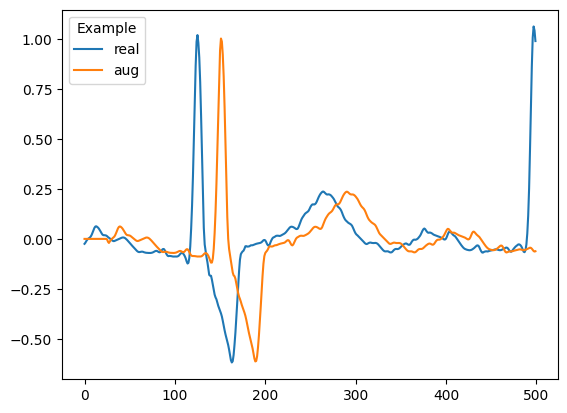

In [28]:
plt.plot(test_beat[0], label = "real") 
plt.plot(augmented[0], label = "aug") 
plt.legend(title="Example") 
plt.show()

оверсэмпл данных кроме нормальный до такого же количества как и норм пациентов c помощью аугов

In [29]:
balanced_df = oversample(train_annotations, majority_target=TARGETS.index('0000001'))

  0%|          | 0/7 [00:00<?, ?it/s]

In [30]:
balanced_df.sum()

new_name                  11181_hr_n001399_hr_n608266_hr_n521231_hr_n007...
target                                                                29022
перегородочный                                                         1382
передний                                                               1382
боковой                                                                1382
передне-боковой                                                        1382
передне-перегородочный                                                 1382
нижний                                                                 1382
норма                                                                  1382
dtype: object

In [31]:
print("number of validation samples:",len(val_annotations) )
print("number of train samples:",len(balanced_df))

print("validation percentage:", len(val_annotations) / len(annotations))
print("train percentage:",len(balanced_df) / len(annotations))

print("VALIDATION myocard percentage", val_annotations["target"].value_counts(normalize=True))
print("TTRAIN myocard percentage", balanced_df["target"].value_counts(normalize=True))

number of validation samples: 4339
number of train samples: 9674
validation percentage: 0.2005083179297597
train percentage: 0.44704251386321625
VALIDATION myocard percentage target
2    0.802950
6    0.073519
4    0.048398
5    0.036875
0    0.030883
3    0.007375
Name: proportion, dtype: float64
TTRAIN myocard percentage target
2    0.142857
0    0.142857
1    0.142857
3    0.142857
4    0.142857
5    0.142857
6    0.142857
Name: proportion, dtype: float64


In [32]:
val_annotations.to_csv('./val_annotations.csv', index=False)
balanced_df.to_csv('./train_annotations.csv', index=False)